Welcome to this notebook. In this notebook some simple classifier algorithms are demonstrated.
In the first 4 chapters a (bad) k-NN solution is demonstrated. In the next chapers better solutions are given.
Written by Bart Bozon, please copy & use as you would like.

# Data understanding - explore data #

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/bbozon/DataScience/refs/heads/main/Fish.csv'
#
# origin: https://documentation.sas.com/doc/en/statug/15.2/statug_sashelp_sect012.htm
# For each of the seven species (bream, roach, whitefish, parkki, perch, pike, and smelt),
# the weight, length, height, and width of each fish are tallied.
# Three different length measurements are recorded: from the nose of the fish to the beginning
# of its tail, from the nose to the notch of its tail, and from the nose to the end of its tail.
#
df = pd.read_csv(url)
df.head()

,Category,Species,Weight,Height,Width,Length1,Length2,Length3
0,1,Bream,242.0,11.5200,4.0200,23.2,25.4,30.0
1,1,Bream,290.0,12.4800,4.3056,24.0,26.3,31.2
2,1,Bream,340.0,12.3778,4.6961,23.9,26.5,31.1
3,1,Bream,363.0,12.7300,4.4555,26.3,29.0,33.5
4,1,Bream,430.0,12.4440,5.1340,26.5,29.0,34.0


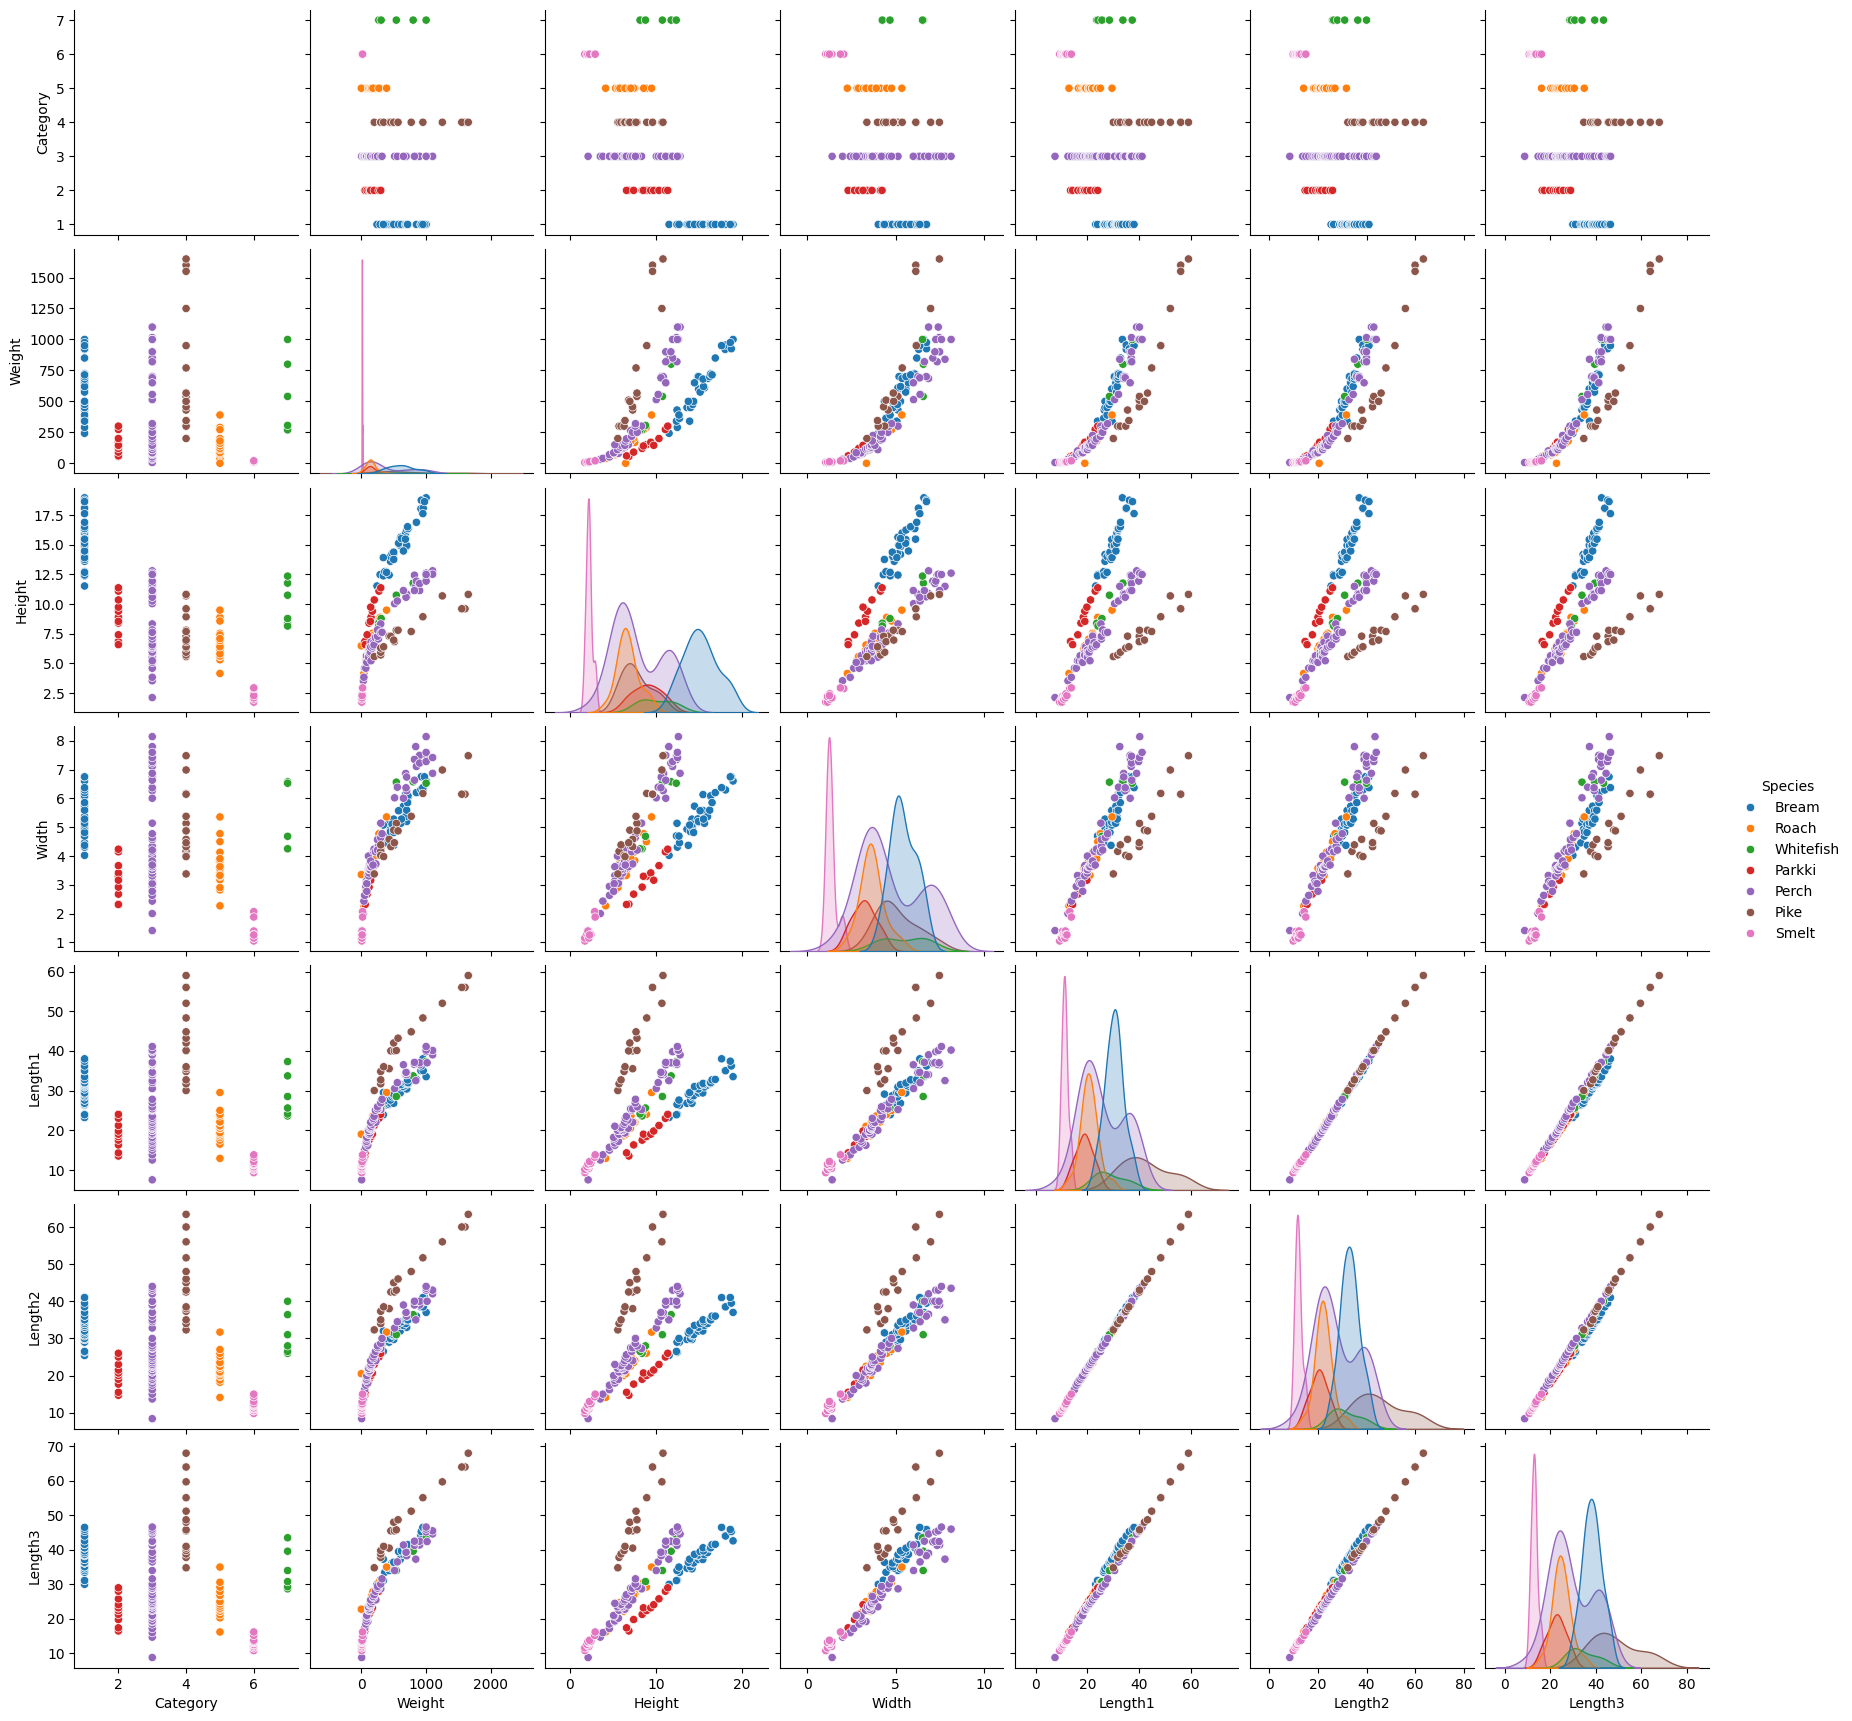

In [2]:
import seaborn as sns
sns.pairplot(df, hue="Species")

/tmp/ipykernel_4839/4114704950.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Weight', y='Species', inner='stick', palette='Dark2')


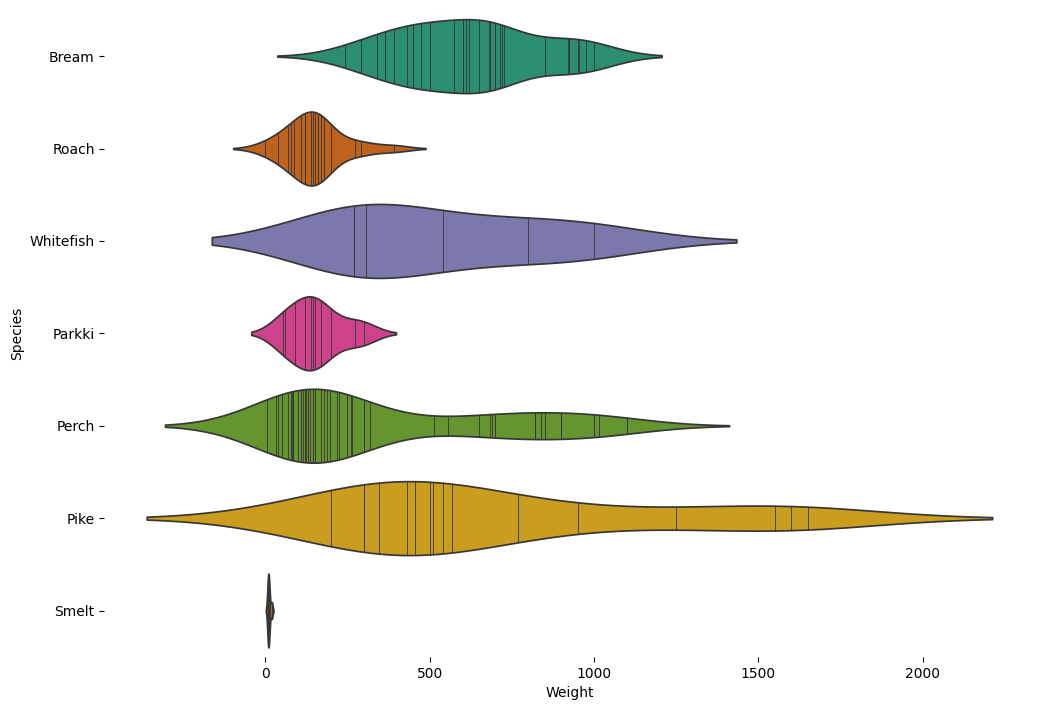

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Species'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Weight', y='Species', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipykernel_4839/395986626.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[df['Species'] == species]['Weight'] for species in df['Species'].unique()], labels=df['Species'].unique())


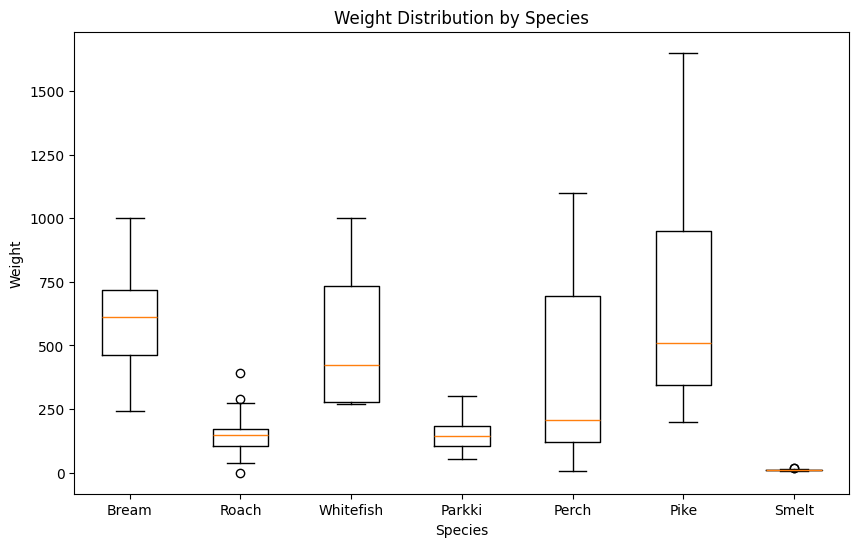

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.boxplot([df[df['Species'] == species]['Weight'] for species in df['Species'].unique()], labels=df['Species'].unique())
plt.xlabel('Species')
plt.ylabel('Weight')
_ = plt.title('Weight Distribution by Species')

<Axes: xlabel='Height', ylabel='Weight'>

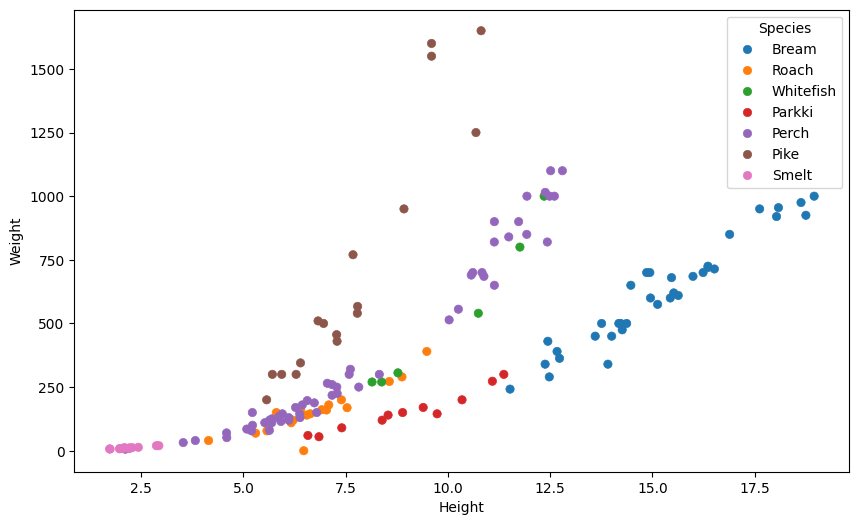

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Height', y='Weight', data=df, hue='Species', ec=None)


# Modelling - generate test design #

In [6]:
X=df.drop(['Category','Species','Length1','Width','Length2','Length3'],axis=1)   # we only want to use Weight and Height as features, drop the rest
y=df['Species']                                                                 # we want to predict the species of the fish
print (X.head())
print (y.head())

   Weight   Height
0   242.0  11.5200
1   290.0  12.4800
2   340.0  12.3778
3   363.0  12.7300
4   430.0  12.4440
0    Bream
1    Bream
2    Bream
3    Bream
4    Bream
Name: Species, dtype: object


In [7]:
from sklearn.model_selection import train_test_split
# we always want to work with a training, validation and test data set
X_train, X_valid_plus_test, y_train, y_valid_plus_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test,y_validation = train_test_split(X_valid_plus_test, y_valid_plus_test, test_size=0.5, random_state=42)
print (X_train.shape)
print (X_validation.shape)
print (X_test.shape)

(127, 2)
(16, 2)
(16, 2)


# Modelling - build model #

In [8]:
from sklearn.neighbors import KNeighborsClassifier                              # we will try a k-NN
model = KNeighborsClassifier(n_neighbors=1)                                     # with k=1
model.fit(X_train, y_train)                                                     # train the model

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


# Modelling - assess model #

accuracy is : 0.5


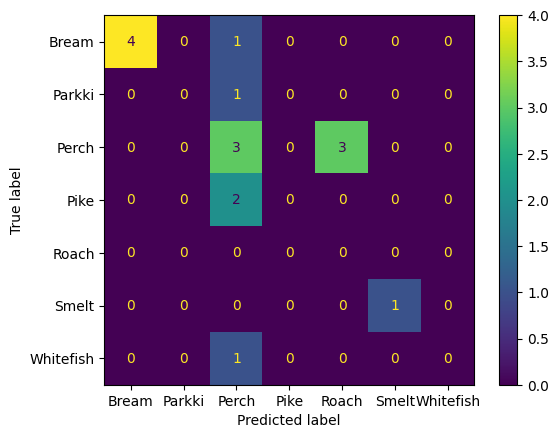

In [9]:
pred = model.predict(X_validation)
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_validation, pred)
print ('accuracy is :',accuracy_score(y_validation, pred))


The results are not very good... What is wrong?

/home/robin/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


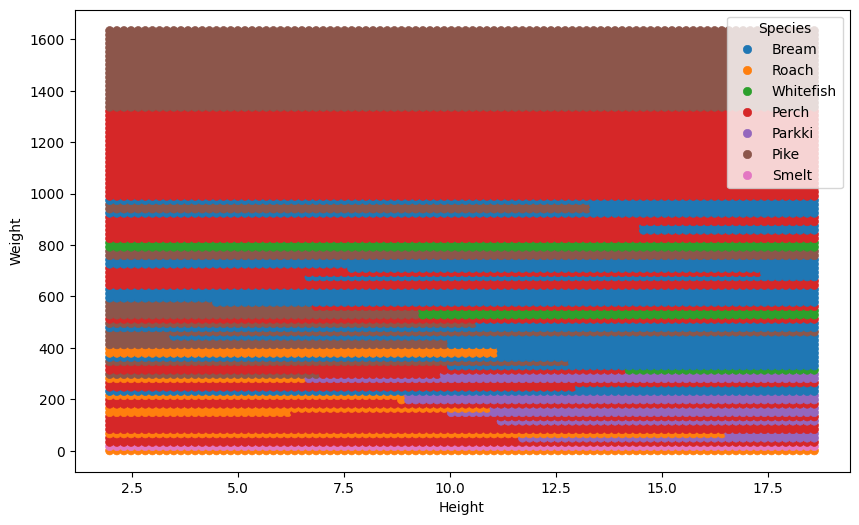

In [10]:
# I made some code to specificly test & visualize the problem. It is only useful for this specific type (2 axis).
# to reuse it I made a function of it (the def)
def show_solution_space():
  X_list=[]
  for i in range (100):
    for j in range (100):
      #X_list.append([i/100*(X_train.max()[0]-X_train.min()[0])+X_train.min()[0],j/100*(X_train.max()[1]-X_train.min()[1])+X_train.min()[1]])
      X_list.append([i/100*(X_train.iloc[:, 0].max()-X_train.iloc[:, 0].min())+X_train.iloc[:, 0].min(),j/100*(X_train.iloc[:, 1].max()-X_train.iloc[:, 1].min())+X_train.iloc[:, 1].min()])
  df2 = pd.DataFrame(data=X_list,columns=["Weight","Height"])
  pred = model.predict(X_list)
  df2['Species'] = pred
  import matplotlib.pyplot as plt
  plt.figure(figsize=(10,6))
  hue_order = ["Bream", "Roach","Whitefish","Perch","Parkki","Pike","Smelt"]
  sns.scatterplot(x='Height', y='Weight', data=df2, hue='Species', ec=None, hue_order=hue_order)

show_solution_space()

Aha! We clearly forgot to scale our data. The weight axis is dominating everything.

# k-NN - now with scaling #

In [11]:
from sklearn.model_selection import train_test_split
# we always want to work with a training, validation and test data set
X_train, X_valid_plus_test, y_train, y_valid_plus_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test,y_validation = train_test_split(X_valid_plus_test, y_valid_plus_test, test_size=0.5, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_temp = scaler.transform(X_train)                                              # scaling the train data set
X_train = pd.DataFrame(X_temp, columns=X_train.columns)
X_temp = scaler.transform(X_validation)                                              # scaling the test data set
X_validation = pd.DataFrame(X_temp, columns=X_validation.columns)
X_temp = scaler.transform(X_test)                                              # scaling the test data set
X_test = pd.DataFrame(X_temp, columns=X_test.columns)
print (X_train.head)

<bound method NDFrame.head of        Weight    Height
0   -0.956314 -1.062734
1    0.513975 -0.259441
2   -0.133465  0.891871
3   -0.760941 -0.681725
4   -0.646855 -0.449896
..        ...       ...
122 -0.247552  0.638351
123 -0.390160 -0.252311
124  0.608097  1.538754
125 -0.675376 -0.510502
126 -0.247552 -0.126128

[127 rows x 2 columns]>


accuracy is : 0.8125


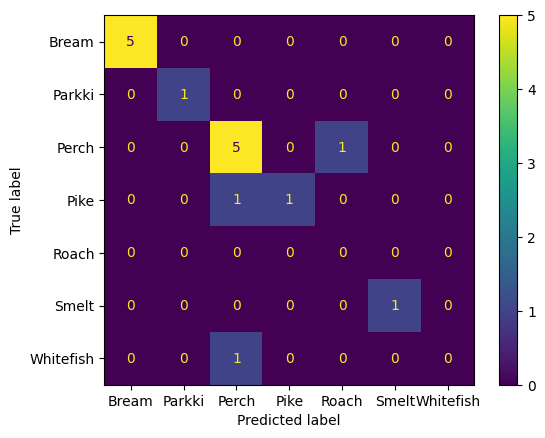

In [12]:
from sklearn.neighbors import KNeighborsClassifier                              # we will try a k-NN
model = KNeighborsClassifier(n_neighbors=1)                                     # with k=1
model.fit(X_train, y_train)                                                     # train the model
pred = model.predict(X_validation)
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_validation, pred)
print ('accuracy is :',accuracy_score(y_validation, pred))


Much better result!

/home/robin/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


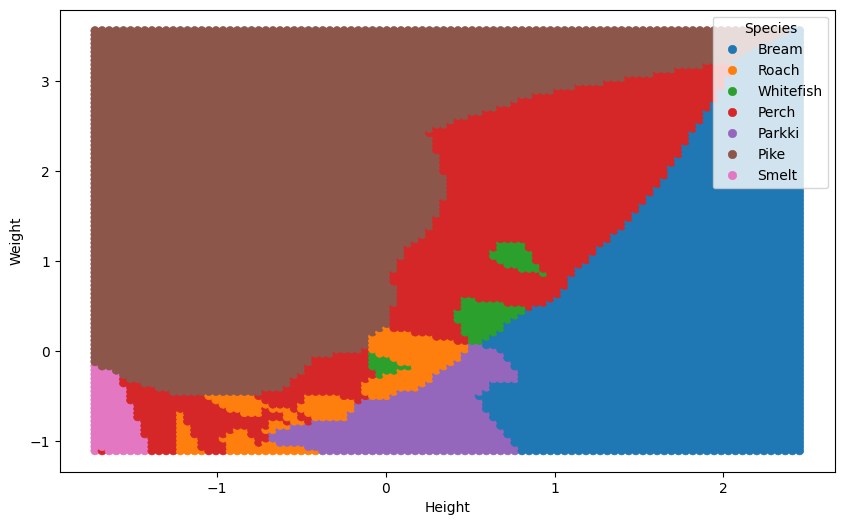

In [13]:
show_solution_space()

This looks much better.

# k-NN - trying out different k #

19


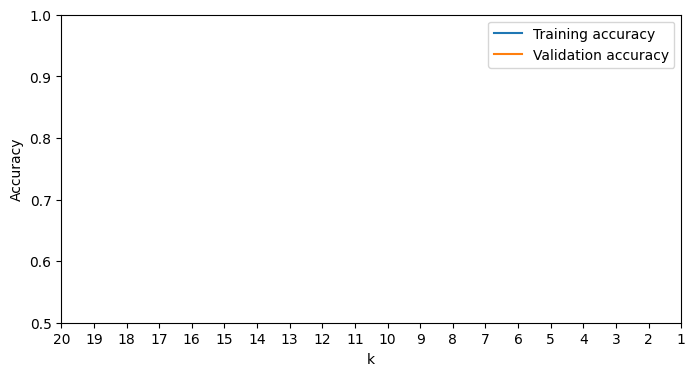

18


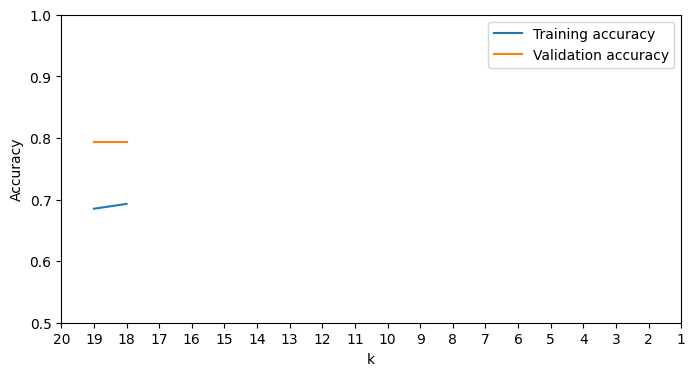

17


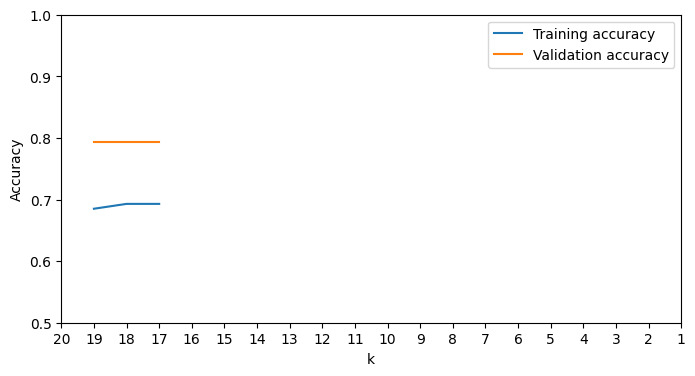

16


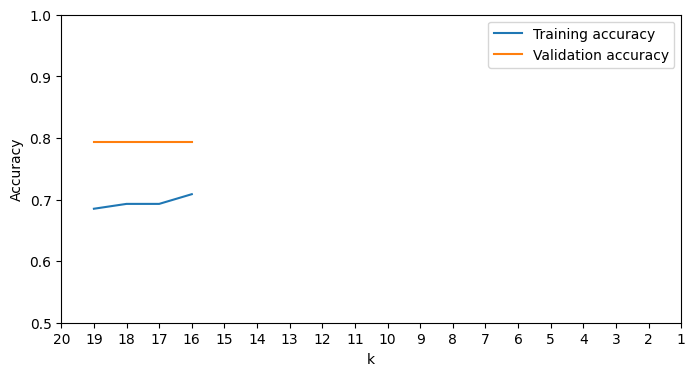

15


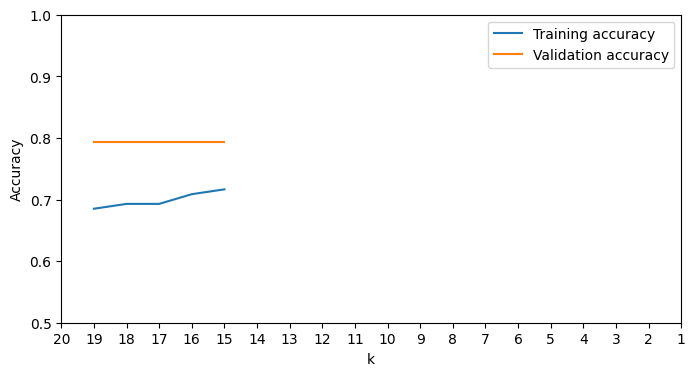

14


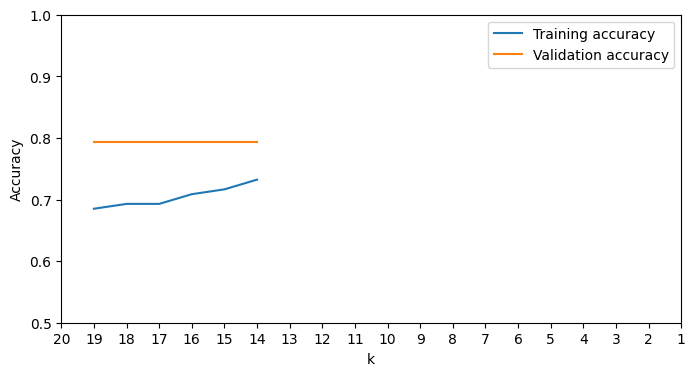

13


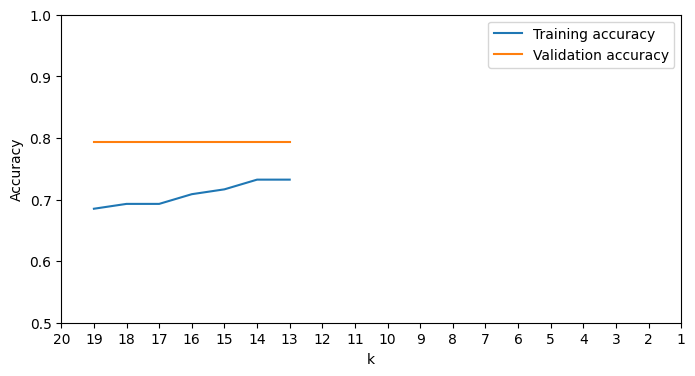

12


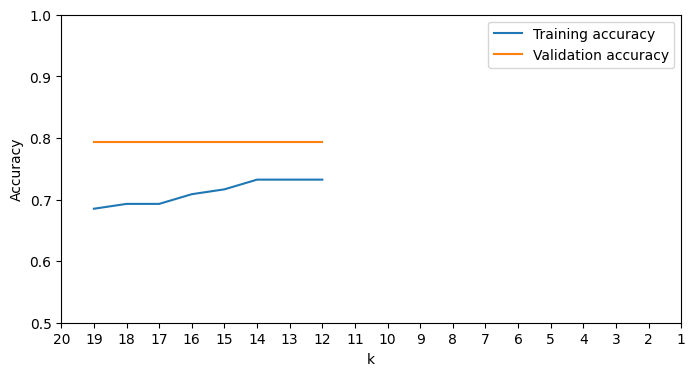

11


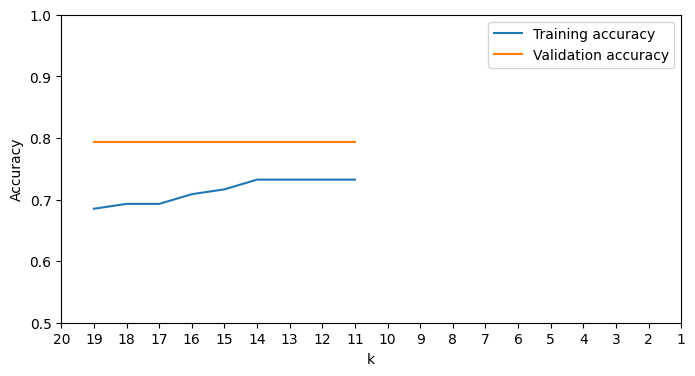

10


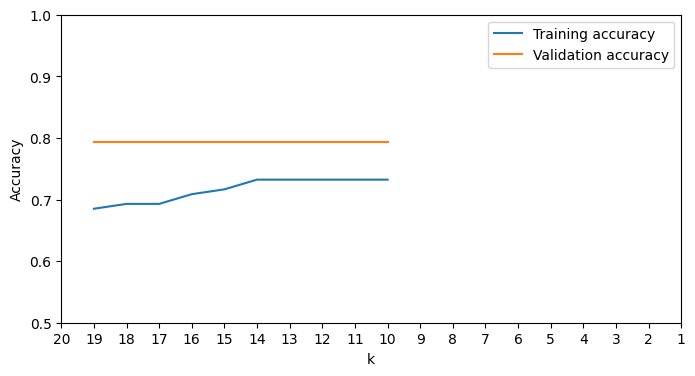

9


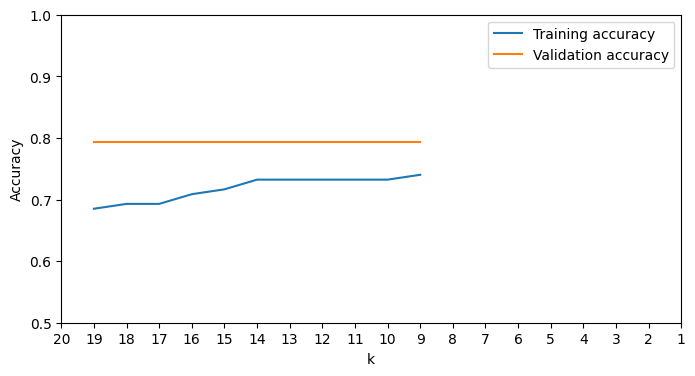

8


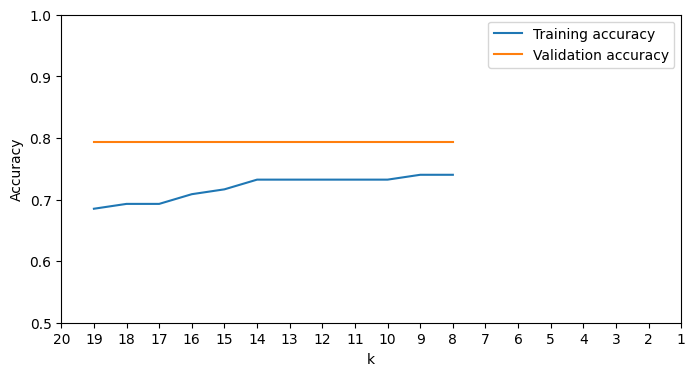

7


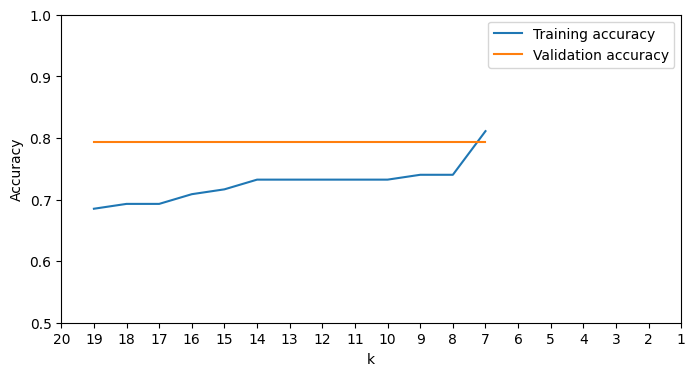

6


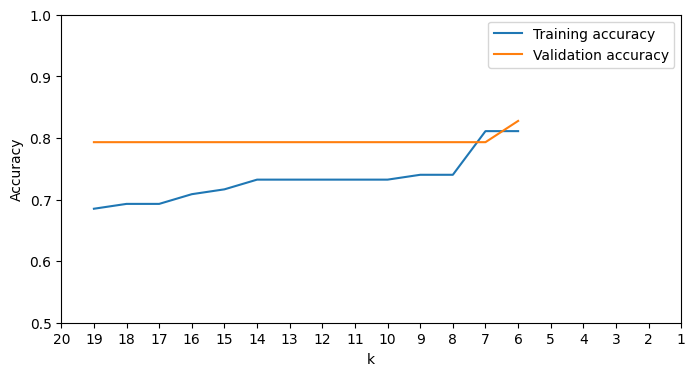

5


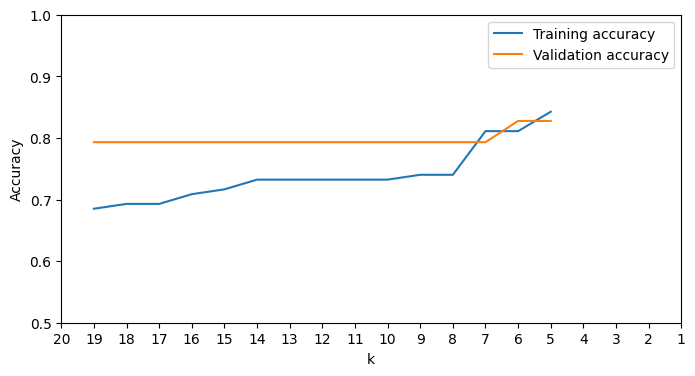

4


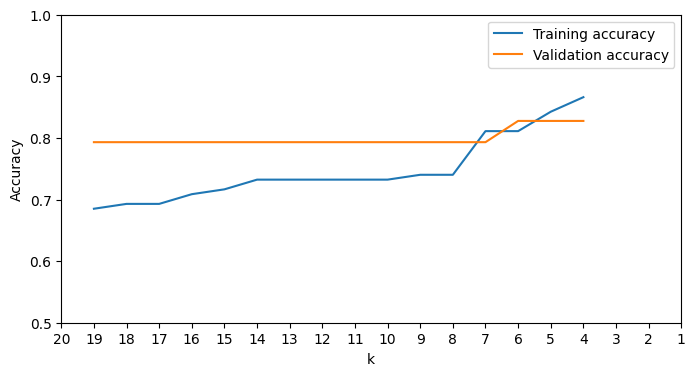

3


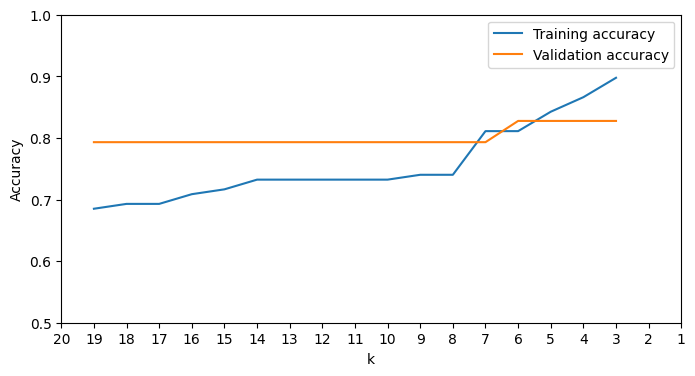

2


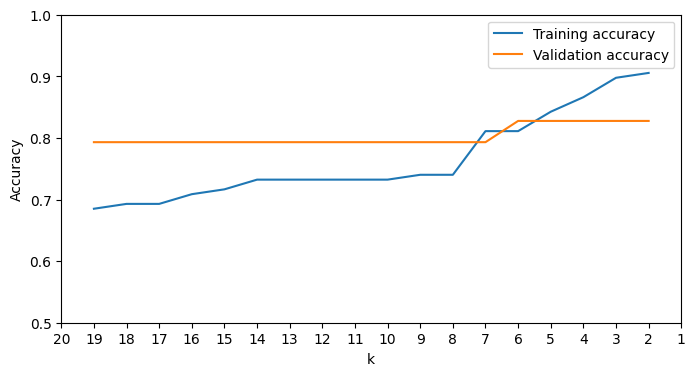

1


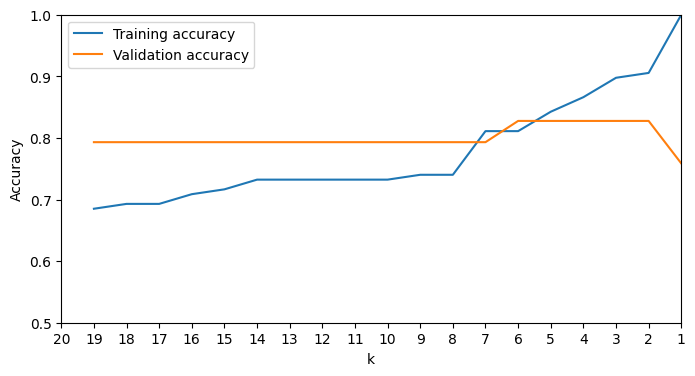

In [14]:
import numpy as np
X=df.drop(['Category','Species','Length1','Width','Length2','Length3'],axis=1)   # we only want to use Weight and Height as features, drop the rest
y=df['Species']                                                                 # we want to predict the species of the fish
from sklearn.model_selection import train_test_split
# we always want to work with a training, validation and test data set
X_train, X_valid_plus_test, y_train, y_valid_plus_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test,y_validation = train_test_split(X_valid_plus_test, y_valid_plus_test, test_size=0.9, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_temp = scaler.transform(X_train)                                              # scaling the train data set
X_train = pd.DataFrame(X_temp, columns=X_train.columns)
X_temp = scaler.transform(X_validation)                                              # scaling the test data set
X_validation = pd.DataFrame(X_temp, columns=X_validation.columns)
X_temp = scaler.transform(X_test)                                              # scaling the test data set
X_test = pd.DataFrame(X_temp, columns=X_test.columns)
from sklearn.neighbors import KNeighborsClassifier                              # we will try a k-NN
from sklearn.metrics import accuracy_score
k=[]
training_accuracy=[]
validation_accuracy=[]
for i in reversed(range(1,20)):
  print (i)
  model = KNeighborsClassifier(n_neighbors=i)                                     # with k=1
  model.fit(X_train, y_train)                                                     # train the model
  pred = model.predict(X_validation)
  pred2 = model.predict(X_train)
  k.append(i)
  validation_accuracy.append(accuracy_score(y_validation, pred))
  training_accuracy.append(accuracy_score(y_train, pred2))
  plt.figure(figsize=(8,4))
  plt.plot(k, training_accuracy, label='Training accuracy')
  plt.plot(k, validation_accuracy, label='Validation accuracy')
  plt.xlim(20,1)
  plt.ylim(0.5,1)
  plt.legend()
  plt.xlabel('k')
  plt.ylabel('Accuracy')
  plt.xticks(np.arange(20, 0, step=-1))
  plt.show()
  # Optionally: show the extra graphs, outcomment the next line
  # show_solution_space()


# k-NN - using all the features of the data set #

accuracy is : 0.9375


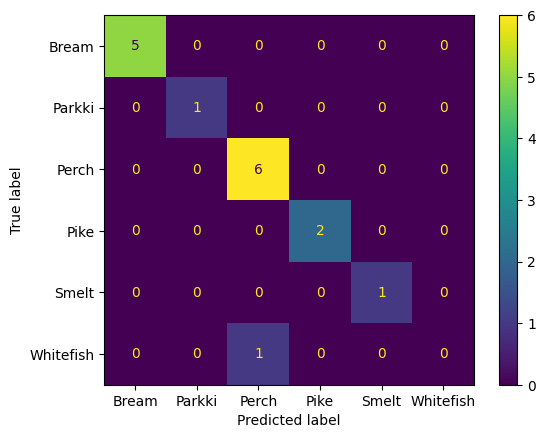

In [15]:
X=df.drop(['Category','Species'],axis=1)                                        # We want to use all the features
y=df['Species']                                                                 # we want to predict the species of the fish
from sklearn.model_selection import train_test_split
# we always want to work with a training, validation and test data set
X_train, X_valid_plus_test, y_train, y_valid_plus_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test,y_validation = train_test_split(X_valid_plus_test, y_valid_plus_test, test_size=0.5, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_temp = scaler.transform(X_train)                                              # scaling the train data set
X_train = pd.DataFrame(X_temp, columns=X_train.columns)
X_temp = scaler.transform(X_validation)                                              # scaling the test data set
X_validation = pd.DataFrame(X_temp, columns=X_validation.columns)
X_temp = scaler.transform(X_test)                                              # scaling the test data set
X_test = pd.DataFrame(X_temp, columns=X_test.columns)
from sklearn.neighbors import KNeighborsClassifier                              # we will try a k-NN
model = KNeighborsClassifier(n_neighbors=1)                                     # with k=1
model.fit(X_train, y_train)                                                     # train the model
pred = model.predict(X_validation)
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_validation, pred)
print ('accuracy is :',accuracy_score(y_validation, pred))

# Decision tree #

accuracy is : 0.8125


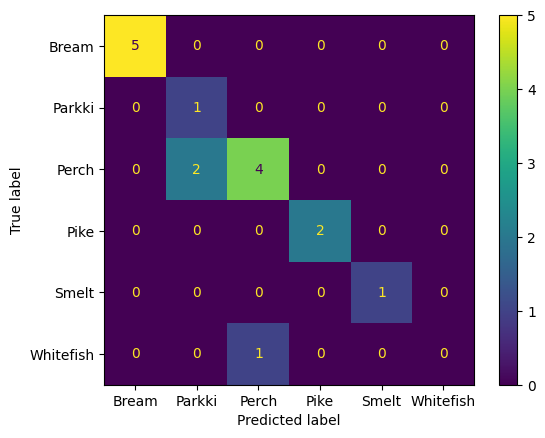

In [16]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)                                                     # train the model
pred = model.predict(X_validation)
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_validation, pred)
print ('accuracy is :',accuracy_score(y_validation, pred))

# Random forest #

accuracy is : 0.875


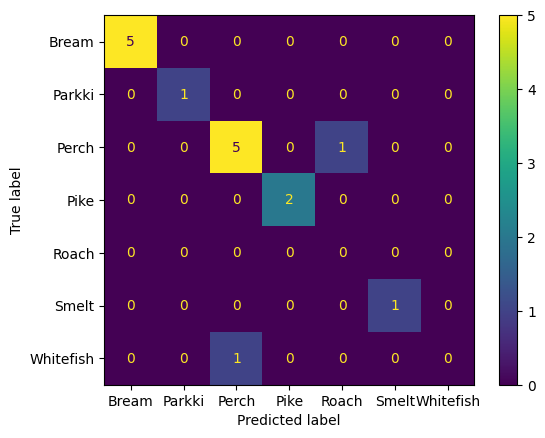

In [17]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model.fit(X_train, y_train)                                                     # train the model
pred = model.predict(X_validation)
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_validation, pred)
print ('accuracy is :',accuracy_score(y_validation, pred))

# Support vector classifier #

accuracy is : 0.9375


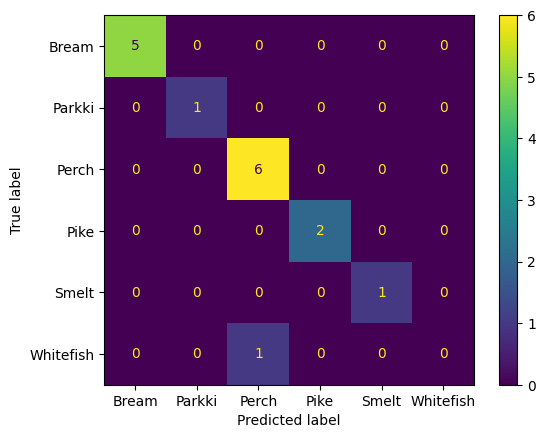

In [18]:
from sklearn.svm import SVC
model = SVC(C=1,gamma=1)
model.fit(X_train, y_train)                                                     # train the model
pred = model.predict(X_validation)
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_validation, pred)
print ('accuracy is :',accuracy_score(y_validation, pred))

Lastly some code to show the performance of the models on the dataset with only two features (Weight and Height). The performance is not really relevant (for instance the SVM really underperforms in this setting, but the visualisation is easier.   

accuracy is : 0.6875


/home/robin/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


accuracy is : 0.875


/home/robin/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


accuracy is : 0.5625


/home/robin/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


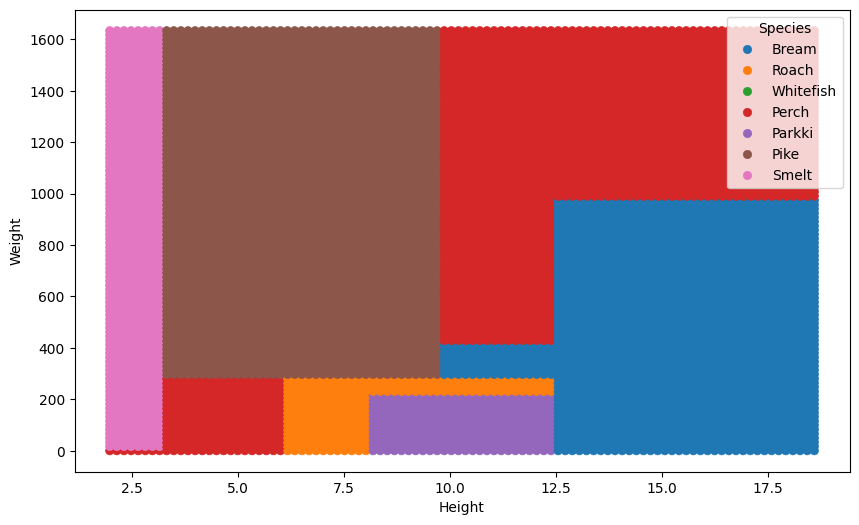

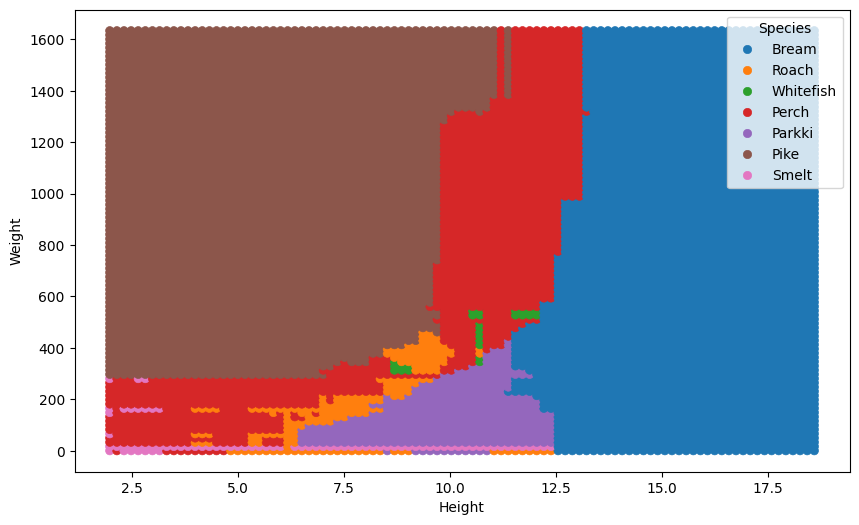

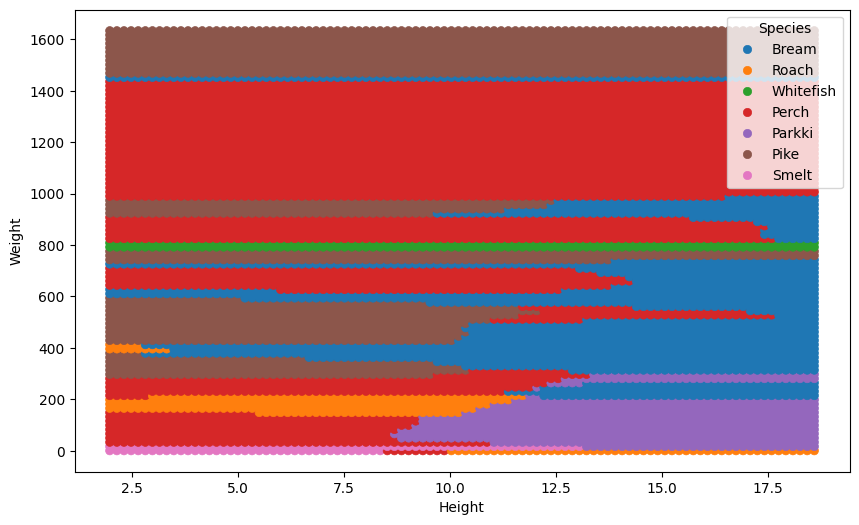

In [19]:
X=df.drop(['Category','Species','Length1','Width','Length2','Length3'],axis=1)   # we only want to use Weight and Height as features, drop the rest
y=df['Species']                                                                 # we want to predict the species of the fish
from sklearn.model_selection import train_test_split
# we always want to work with a training, validation and test data set
X_train, X_valid_plus_test, y_train, y_valid_plus_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test,y_validation = train_test_split(X_valid_plus_test, y_valid_plus_test, test_size=0.5, random_state=42)

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)                                                     # train the model
pred = model.predict(X_validation)
print ('accuracy is :',accuracy_score(y_validation, pred))
show_solution_space()

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model.fit(X_train, y_train)                                                     # train the model
pred = model.predict(X_validation)
print ('accuracy is :',accuracy_score(y_validation, pred))
show_solution_space()

from sklearn.svm import SVC
model = SVC(C=100,gamma=0.0001)         # I've changed the hyperparameters to optimize for 2 feature dataset
model.fit(X_train, y_train)                                                     # train the model
pred = model.predict(X_validation)
print ('accuracy is :',accuracy_score(y_validation, pred))
show_solution_space()
